In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf

import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10256139447701908679
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82767642624
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 5766018089187113800
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-09-22 17:04:13.567255: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 17:04:14.497769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0
2023-09-22 17:04:14.507689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

# def get_full_scan(folder_path):

#     files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
#     itkimage = sitk.ReadImage(files_List[0])
#     rows = int(itkimage.GetMetaData('0028|0010'))
#     cols = int(itkimage.GetMetaData('0028|0011'))
    
#     a = itkimage.GetMetaData('0028|0030')
#     c = itkimage.GetMetaData('0018|0050')
#     #print('z spacing ',c)
#     #print('xy spacing: ',a)
#     mn = 1000
#     mx = 0
#     for file in (files_List):
#         itkimage = sitk.ReadImage(file)
#         mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
#         mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
#     full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
#     for file in (files_List):
#         img, n = dcm_image(file)
#         n = int(n)
#         full_scan[n-mn,:,:] = img[0,:,:]
#     return full_scan

# def dcm_image(filename):
#     itkimage = sitk.ReadImage(filename)
#     numpyImage = sitk.GetArrayFromImage(itkimage)
#     ins = float(itkimage.GetMetaData('0020|0013'))
#     return numpyImage, ins

# import copy
# def get_normalized(scann,mn,mx):
#     scan = copy.copy(scann)
#     mn = max(mn,np.amin(scan))
#     mx = min(mx,np.amax(scan))
#     np.clip(scan, mn, mx, out=scan)
#     d = mx - mn
#     scan = (scan-mn)/d
#     return scan

# def res_scan(nscan,image_size):

#     depth_factor = image_size[0]/nscan.shape[0]
#     width_factor = image_size[2]/nscan.shape[2]
#     height_factor = image_size[1]/nscan.shape[1]
#     nscann = copy.copy(nscan)
#     nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
#     return nscann

# def res_mask(nmask,image_size):
#     depth_factor = image_size[0]/nmask.shape[0]
#     width_factor = image_size[2]/nmask.shape[2]
#     height_factor = image_size[1]/nmask.shape[1]

#     nmaskk = copy.copy(nmask)
#     nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
#     return nmaskk

In [3]:
imgpath = glob.glob("/home/rabeea/Kvasir/images/*.jpg", recursive = True)
print(len(imgpath))

1000


In [4]:
tr = 700
val = 100
ts = 200
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))

1000 700 100 200


In [5]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = "/home/rabeea/Kvasir/masks/" + img_path.split('/')[-1]
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.where(mask>50,255,0)
    mask = cv2.resize(mask.astype(np.uint8),image_size, interpolation = cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            #print(images_path[i])
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(images_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [6]:
image_size = (256,256)
batch_size = 1

epochs = 200

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, batch_size=batch_size)
test_gen = DataGen(image_size,testpath, batch_size=1)

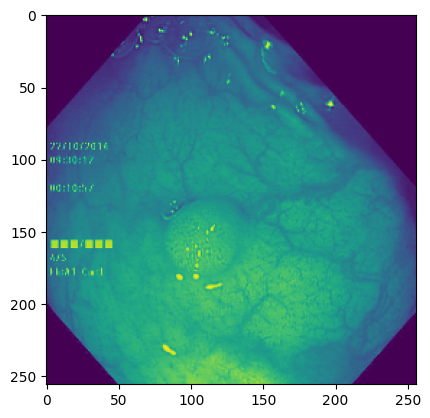

In [7]:
t = train_gen.__getitem__(3)[0]
p = train_gen.__getitem__(3)[1]
plt.imshow(t[0,:,:,0])

In [8]:
t.shape

(1, 256, 256, 1)

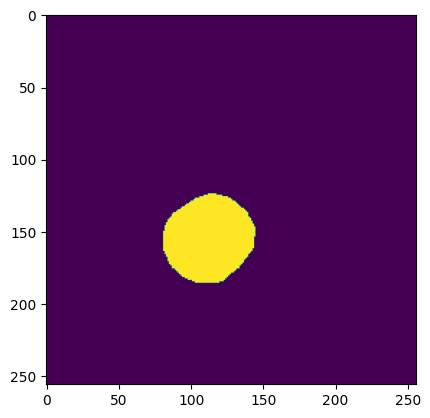

In [9]:
plt.imshow(p[0,:,:,0])

In [10]:
import encoder_layers as encoder_layers
import decoder_layers as decoder_layers
from resnet_v2 import  resnet_embeddings
from transformerskipabl import tskip
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import utils as utils
import math

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file 

In [11]:
def TransUNet(image_size=256, 
                patch_size=16, 
                hybrid=True,
                grid=(14,14), 
                hidden_size=768,
                n_layers=12,
                n_heads=12,
                mlp_dim=3072,
                dropout=0.1,
                decoder_channels=[256,128,64,16],
                n_skip=3,
                num_classes=1,
                final_act='sigmoid',
                pretrain=False,
                freeze_enc_cnn=True,
                name='TransUNet'):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 1))

    # Embedding
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1

        resnet50v2, features = resnet_embeddings(x, image_size=image_size, n_skip=n_skip, pretrain=pretrain)
        print(len(features))
        for d in features:
            print(d.shape)
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=True
    )(y)
    y = tfkl.Reshape(
        (y.shape[1] * y.shape[2], hidden_size))(y)
    y = encoder_layers.AddPositionEmbs(
        name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = encoder_layers.TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True
        )(y)
    y = tfkl.LayerNormalization(
        epsilon=1e-6, name="Transformer/encoder_norm"
    )(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(
        target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder CUP
    if len(decoder_channels):
        print('after reverting')
        features = features[::-1]
        for d in features:
            print(d.shape)
        features = tskip(features,embedding_dim = 4, dim = 8, heads = 2, up=4, abl='cross')
        for d in features:
            print(d.shape)
        features = features[::-1]
        for d in features:
            print(d.shape)
        y = decoder_layers.DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = decoder_layers.SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model =  tfk.models.Model(inputs=x, outputs=y, name=name)
    
    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)
        
    return model


In [12]:
a = TransUNet()
a.compile(optimizer = tf.keras.optimizers.SGD(lr = 1e-3), loss=dice_loss, metrics = [dice_coef])
a.summary()

2023-09-22 17:05:27.310025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


3
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 64)
after reverting
(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
vocab size:  4096
vocab size:  4096
vocab size:  2048
(None, 128, 128, 64)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 64)
Model: "TransUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 1)  0           ['input_2[0][0]']                
                                                                       

                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 64, 64, 256)  1024       ['conv2_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_blo

 conv3_block2_2_pad (ZeroPaddin  (None, 34, 34, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 32, 32, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
          

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


                                                                  'conv3_block4_3_conv[0][0]']    
                                                                                                  
 conv4_block1_preact_bn (BatchN  (None, 16, 16, 512)  2048       ['conv3_block4_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block1_preact_relu (Acti  (None, 16, 16, 512)  0          ['conv4_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 16, 16, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
          

                                                                                                  
 conv4_block3_2_pad (ZeroPaddin  (None, 18, 18, 256)  0          ['conv4_block3_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 16, 16, 256)  589824      ['conv4_block3_2_pad[0][0]']     
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)       

 max_pooling2d_13 (MaxPooling2D  (None, 4, 4, 512)   0           ['max_pooling2d_12[0][0]']       
 )                                                                                                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 16, 16, 64)  0           ['max_pooling2d_4[0][0]']        
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 8, 8, 256)   0           ['max_pooling2d_8[0][0]']        
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  589824      ['conv4_block5_2_pad[0][0]']     
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 2, 2, 512)   0           ['max_pooling2d_13[0][0]']       
 )        

 rearrange_5 (Rearrange)        (1, None, 2, 4096,   0           ['dense_5[0][0]']                
                                4)                                                                
                                                                                                  
 rearrange_1 (Rearrange)        (1, None, 2, 4096,   0           ['dense_1[0][0]']                
                                4)                                                                
                                                                                                  
 rearrange (Rearrange)          (1, None, 2, 4096,   0           ['dense[0][0]']                  
                                4)                                                                
                                                                                                  
 embedding (Conv2D)             (None, 16, 16, 768)  787200      ['conv4_block6_preact_relu[0][0]'
          

                                4)                                                                
                                                                                                  
 tf.nn.softmax_2 (TFOpLambda)   (None, 2, 4096, 409  0           ['tf.math.multiply_2[0][0]']     
                                6)                                                                
                                                                                                  
 Transformer/encoderblock_0 (Tr  ((None, 256, 768),  7087872     ['dropout[0][0]']                
 ansformerBlock)                 (None, 12, None, N                                               
                                one))                                                             
                                                                                                  
 tf.einsum_3 (TFOpLambda)       (None, 2, 2048, 4)   0           ['tf.nn.softmax_1[0][0]',        
          

                                                                  'tf.__operators__.getitem_8[0][0
                                                                 ]']                              
                                                                                                  
 tf.einsum_9 (TFOpLambda)       (None, 2, 4096, 4)   0           ['tf.nn.softmax_4[0][0]',        
                                                                  'tf.__operators__.getitem_8[0][0
                                                                 ]']                              
                                                                                                  
 Transformer/encoderblock_5 (Tr  ((None, 256, 768),  7087872     ['Transformer/encoderblock_4[0][0
 ansformerBlock)                 (None, 12, None, N              ]']                              
                                one))                                                             
          

                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 16, 16, 256)  0          ['up_sampling2d_4[0][0]']        
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, 32, 32, 64)  0           ['up_sampling2d[0][0]']          
                                                                                                  
 Transformer/encoder_norm (Laye  (None, 256, 768)    1536        ['Transformer/encoderblock_11[0][
 rNormalization)                                                 0]']                             
                                                                                                  
 up_sampling2d_10 (UpSampling2D  (None, 16, 16, 512)  0          ['up_sampling2d_9[0][0]']        
 )                                                                                                
          

In [13]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

filepath = r"/home/rabeea/logs/transskip_transunet_kvasir/4layers_lr3_e4_f64_350_d8_h2_m4_ablcross.h5"

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stopping]

In [14]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/200


2023-09-22 17:06:13.515395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
2023-09-22 17:06:14.537804: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


700/700 [==============================] - 111s 129ms/step - loss: 0.8034 - dice_coef: 0.3408 - val_loss: 0.7204 - val_dice_coef: 0.4238
Epoch 2/200
700/700 [==============================] - 84s 120ms/step - loss: 0.7750 - dice_coef: 0.3692 - val_loss: 0.7066 - val_dice_coef: 0.4376
Epoch 3/200
700/700 [==============================] - 84s 121ms/step - loss: 0.7513 - dice_coef: 0.3928 - val_loss: 0.6379 - val_dice_coef: 0.5062
Epoch 4/200
700/700 [==============================] - 82s 118ms/step - loss: 0.7186 - dice_coef: 0.4255 - val_loss: 0.6276 - val_dice_coef: 0.5166
Epoch 5/200
700/700 [==============================] - 83s 119ms/step - loss: 0.6967 - dice_coef: 0.4474 - val_loss: 0.6014 - val_dice_coef: 0.5427
Epoch 6/200
700/700 [==============================] - 82s 117ms/step - loss: 0.6841 - dice_coef: 0.4599 - val_loss: 0.6103 - val_dice_coef: 0.5338
Epoch 7/200
671/700 [===========================>..] - ETA: 3s - loss: 0.6794 - dice_coef: 0.4647

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 83s 118ms/step - loss: 0.6330 - dice_coef: 0.5104 - val_loss: 0.5680 - val_dice_coef: 0.5755
Epoch 23/200
700/700 [==============================] - 83s 119ms/step - loss: 0.6304 - dice_coef: 0.5131 - val_loss: 0.5659 - val_dice_coef: 0.5776
Epoch 24/200
700/700 [==============================] - 81s 116ms/step - loss: 0.6294 - dice_coef: 0.5140 - val_loss: 0.5694 - val_dice_coef: 0.5740
Epoch 25/200
700/700 [==============================] - 84s 121ms/step - loss: 0.6259 - dice_coef: 0.5175 - val_loss: 0.5656 - val_dice_coef: 0.5777
Epoch 26/200
293/700 [===========>..................] - ETA: 43s - loss: 0.6187 - dice_coef: 0.5247

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 82s 117ms/step - loss: 0.6058 - dice_coef: 0.5369 - val_loss: 0.5670 - val_dice_coef: 0.5758
Epoch 41/200
700/700 [==============================] - 82s 117ms/step - loss: 0.6056 - dice_coef: 0.5372 - val_loss: 0.5541 - val_dice_coef: 0.5887
Epoch 42/200
700/700 [==============================] - 81s 116ms/step - loss: 0.6039 - dice_coef: 0.5388 - val_loss: 0.5539 - val_dice_coef: 0.5888
Epoch 43/200
700/700 [==============================] - 82s 117ms/step - loss: 0.6042 - dice_coef: 0.5385 - val_loss: 0.5562 - val_dice_coef: 0.5865
Epoch 44/200
553/700 [======================>.......] - ETA: 16s - loss: 0.6039 - dice_coef: 0.5388

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 82s 117ms/step - loss: 0.5846 - dice_coef: 0.5576 - val_loss: 0.5569 - val_dice_coef: 0.5852
Epoch 59/200
700/700 [==============================] - 81s 116ms/step - loss: 0.5845 - dice_coef: 0.5576 - val_loss: 0.5641 - val_dice_coef: 0.5780
Epoch 60/200
700/700 [==============================] - 82s 117ms/step - loss: 0.5836 - dice_coef: 0.5584 - val_loss: 0.5590 - val_dice_coef: 0.5831
Epoch 61/200
700/700 [==============================] - 83s 118ms/step - loss: 0.5813 - dice_coef: 0.5607 - val_loss: 0.5534 - val_dice_coef: 0.5885
Epoch 62/200
700/700 [==============================] - 82s 117ms/step - loss: 0.5810 - dice_coef: 0.5609 - val_loss: 0.5539 - val_dice_coef: 0.5880
Epoch 63/200
189/700 [=======>......................] - ETA: 55s - loss: 0.5688 - dice_coef: 0.5731

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 80s 115ms/step - loss: 0.5625 - dice_coef: 0.5789 - val_loss: 0.5759 - val_dice_coef: 0.5655
Epoch 77/200
700/700 [==============================] - 81s 116ms/step - loss: 0.5601 - dice_coef: 0.5813 - val_loss: 0.5794 - val_dice_coef: 0.5620
Epoch 78/200
700/700 [==============================] - 83s 119ms/step - loss: 0.5575 - dice_coef: 0.5839 - val_loss: 0.5758 - val_dice_coef: 0.5656
Epoch 79/200
700/700 [==============================] - 79s 114ms/step - loss: 0.5566 - dice_coef: 0.5848 - val_loss: 0.5881 - val_dice_coef: 0.5532
Epoch 80/200
596/700 [========================>.....] - ETA: 11s - loss: 0.5508 - dice_coef: 0.5906

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
a.load_weights(filepath)

In [16]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

training dice:  0.5952073335647583
validation dice:  0.5939635038375854


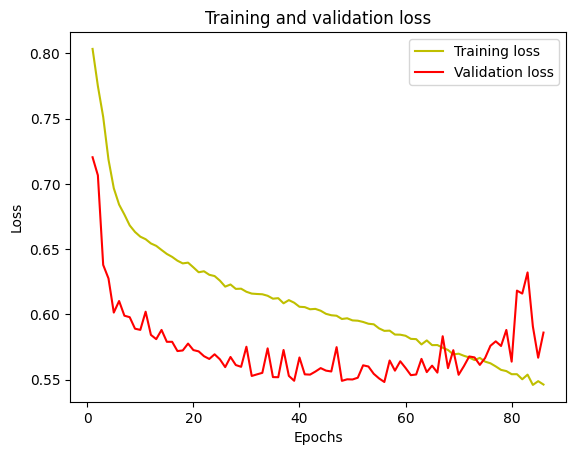

In [17]:

#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

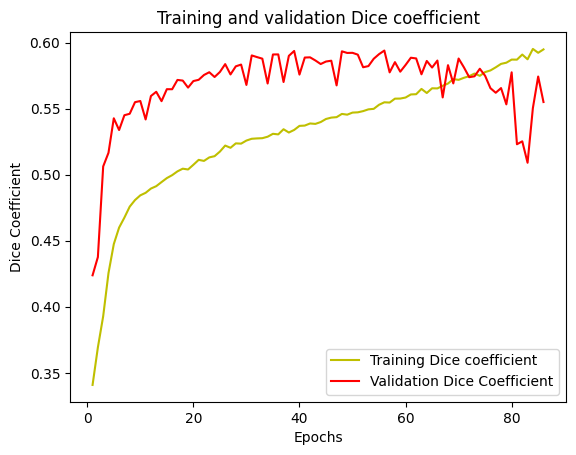

In [18]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [19]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                   | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_1835534/1823746687.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_1835534/1823746687.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|███████████████

at 0.9: dice:  0.4553418469875132
at 0.8: dice:  0.47288483993893143
at 0.7: dice:  0.48651275990708565
at 0.6: dice:  0.4977159042599948
at 0.5: dice:  0.5060790000097117
at 0.4: dice:  0.5101277983111433
at 0.3: dice:  0.5020970792237658
at 0.2: dice:  0.47992781877725293
at 0.1: dice:  0.4215439079826283
at 0.05: dice:  0.3621185306173525
at 0.01: dice:  0.26349008639875043


# witout TRANSSKIP

In [13]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = r"/home/rabeea/logs/transunet_kvasir/4layers_lr3_f64_l12_200.h5"
tensorboard = TensorBoard(log_dir=r"/home/rabeea/logs/transunet_kvasir/4layers_lr3_f64_l12_200", histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [14]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/200


2023-05-30 15:56:07.710199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
2023-05-30 15:56:08.749206: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


700/700 [==============================] - 111s 131ms/step - loss: 0.7796 - dice_coef: 0.3644 - val_loss: 0.6821 - val_dice_coef: 0.4619
Epoch 2/200
700/700 [==============================] - 89s 128ms/step - loss: 0.7395 - dice_coef: 0.4045 - val_loss: 0.6361 - val_dice_coef: 0.5078
Epoch 3/200
700/700 [==============================] - 89s 127ms/step - loss: 0.7139 - dice_coef: 0.4300 - val_loss: 0.6235 - val_dice_coef: 0.5204
Epoch 4/200
700/700 [==============================] - 89s 127ms/step - loss: 0.6944 - dice_coef: 0.4495 - val_loss: 0.6090 - val_dice_coef: 0.5349
Epoch 5/200
700/700 [==============================] - 89s 127ms/step - loss: 0.6833 - dice_coef: 0.4606 - val_loss: 0.6015 - val_dice_coef: 0.5424
Epoch 6/200
700/700 [==============================] - 87s 124ms/step - loss: 0.6743 - dice_coef: 0.4696 - val_loss: 0.6056 - val_dice_coef: 0.5383
Epoch 7/200
700/700 [==============================] - 88s 126ms/step - loss: 0.6681 - dice_coef: 0.4757 - val_loss: 0.6043

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 89s 127ms/step - loss: 0.6160 - dice_coef: 0.5267 - val_loss: 0.5531 - val_dice_coef: 0.5896
Epoch 37/200
700/700 [==============================] - 86s 123ms/step - loss: 0.6150 - dice_coef: 0.5277 - val_loss: 0.5538 - val_dice_coef: 0.5888
Epoch 38/200
700/700 [==============================] - 88s 126ms/step - loss: 0.6133 - dice_coef: 0.5293 - val_loss: 0.5526 - val_dice_coef: 0.5900
Epoch 39/200
700/700 [==============================] - 89s 126ms/step - loss: 0.6149 - dice_coef: 0.5277 - val_loss: 0.5506 - val_dice_coef: 0.5920
Epoch 40/200
635/700 [==========================>...] - ETA: 6s - loss: 0.6078 - dice_coef: 0.5348

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 87s 124ms/step - loss: 0.6024 - dice_coef: 0.5398 - val_loss: 0.5489 - val_dice_coef: 0.5934
Epoch 49/200
700/700 [==============================] - 87s 124ms/step - loss: 0.6009 - dice_coef: 0.5413 - val_loss: 0.5470 - val_dice_coef: 0.5952
Epoch 50/200
700/700 [==============================] - 87s 125ms/step - loss: 0.6011 - dice_coef: 0.5411 - val_loss: 0.5508 - val_dice_coef: 0.5913
Epoch 51/200
700/700 [==============================] - 87s 124ms/step - loss: 0.5991 - dice_coef: 0.5430 - val_loss: 0.5452 - val_dice_coef: 0.5970
Epoch 52/200
659/700 [===========================>..] - ETA: 4s - loss: 0.6013 - dice_coef: 0.5408

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 86s 123ms/step - loss: 0.5861 - dice_coef: 0.5557 - val_loss: 0.5530 - val_dice_coef: 0.5888
Epoch 62/200
700/700 [==============================] - 87s 125ms/step - loss: 0.5886 - dice_coef: 0.5532 - val_loss: 0.5532 - val_dice_coef: 0.5885
Epoch 63/200
700/700 [==============================] - 87s 124ms/step - loss: 0.5808 - dice_coef: 0.5608 - val_loss: 0.5430 - val_dice_coef: 0.5986
Epoch 66/200
700/700 [==============================] - 87s 124ms/step - loss: 0.5855 - dice_coef: 0.5561 - val_loss: 0.5522 - val_dice_coef: 0.5893
Epoch 67/200
700/700 [==============================] - 87s 124ms/step - loss: 0.5811 - dice_coef: 0.5605 - val_loss: 0.5428 - val_dice_coef: 0.5987
Epoch 68/200
700/700 [==============================] - 88s 125ms/step - loss: 0.5797 - dice_coef: 0.5618 - val_loss: 0.5540 - val_dice_coef: 0.5875
Epoch 69/200
275/700 [==========>...................] - ETA: 41s - loss: 0.5823 - dice_coef: 0.5592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 87s 124ms/step - loss: 0.5647 - dice_coef: 0.5765 - val_loss: 0.5430 - val_dice_coef: 0.5982
Epoch 79/200
700/700 [==============================] - 88s 125ms/step - loss: 0.5644 - dice_coef: 0.5767 - val_loss: 0.5444 - val_dice_coef: 0.5967
Epoch 80/200
700/700 [==============================] - 88s 126ms/step - loss: 0.5614 - dice_coef: 0.5797 - val_loss: 0.5530 - val_dice_coef: 0.5880
Epoch 81/200
700/700 [==============================] - 88s 125ms/step - loss: 0.5594 - dice_coef: 0.5816 - val_loss: 0.5694 - val_dice_coef: 0.5716
Epoch 82/200
700/700 [==============================] - 88s 125ms/step - loss: 0.5594 - dice_coef: 0.5816 - val_loss: 0.5431 - val_dice_coef: 0.5979
Epoch 83/200
700/700 [==============================] - 88s 125ms/step - loss: 0.5566 - dice_coef: 0.5844 - val_loss: 0.5673 - val_dice_coef: 0.5737
Epoch 84/200
700/700 [==============================] - 87s 124ms/step - loss: 0.5554 - dice_coef: 0.5856 - val_loss: 0

Epoch 133/200
700/700 [==============================] - 87s 125ms/step - loss: 0.4540 - dice_coef: 0.6854 - val_loss: 0.5730 - val_dice_coef: 0.5664
Epoch 134/200
496/700 [====================>.........] - ETA: 19s - loss: 0.4414 - dice_coef: 0.6980

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 88s 126ms/step - loss: 0.4116 - dice_coef: 0.7273 - val_loss: 0.5627 - val_dice_coef: 0.5762
Epoch 149/200
700/700 [==============================] - 88s 125ms/step - loss: 0.4039 - dice_coef: 0.7350 - val_loss: 0.6184 - val_dice_coef: 0.5205
Epoch 150/200
700/700 [==============================] - 87s 125ms/step - loss: 0.4052 - dice_coef: 0.7337 - val_loss: 0.6157 - val_dice_coef: 0.5232
Epoch 151/200
700/700 [==============================] - 87s 124ms/step - loss: 0.4010 - dice_coef: 0.7378 - val_loss: 0.6264 - val_dice_coef: 0.5125
Epoch 152/200
651/700 [==========================>...] - ETA: 4s - loss: 0.3968 - dice_coef: 0.7420

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 87s 124ms/step - loss: 0.3602 - dice_coef: 0.7783 - val_loss: 0.6561 - val_dice_coef: 0.4823
Epoch 168/200
700/700 [==============================] - 86s 123ms/step - loss: 0.3540 - dice_coef: 0.7844 - val_loss: 0.6656 - val_dice_coef: 0.4728
Epoch 169/200
700/700 [==============================] - 86s 123ms/step - loss: 0.3520 - dice_coef: 0.7864 - val_loss: 0.6568 - val_dice_coef: 0.4816
Epoch 170/200
700/700 [==============================] - 87s 125ms/step - loss: 0.3482 - dice_coef: 0.7902 - val_loss: 0.6537 - val_dice_coef: 0.4846
Epoch 171/200
553/700 [======================>.......] - ETA: 14s - loss: 0.3433 - dice_coef: 0.7951

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 88s 125ms/step - loss: 0.3127 - dice_coef: 0.8253 - val_loss: 0.7059 - val_dice_coef: 0.4320
Epoch 186/200
700/700 [==============================] - 88s 126ms/step - loss: 0.3066 - dice_coef: 0.8313 - val_loss: 0.6461 - val_dice_coef: 0.4918
Epoch 187/200
700/700 [==============================] - 89s 127ms/step - loss: 0.3050 - dice_coef: 0.8329 - val_loss: 0.6851 - val_dice_coef: 0.4528
Epoch 188/200
700/700 [==============================] - 87s 125ms/step - loss: 0.3072 - dice_coef: 0.8306 - val_loss: 0.6946 - val_dice_coef: 0.4433
Epoch 189/200
700/700 [==============================] - 88s 126ms/step - loss: 0.2995 - dice_coef: 0.8383 - val_loss: 0.6859 - val_dice_coef: 0.4519
Epoch 190/200
 91/700 [==>...........................] - ETA: 1:01 - loss: 0.2912 - dice_coef: 0.8466

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
a.load_weights(filepath)

In [16]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

training dice:  0.8573453426361084
validation dice:  0.6053059697151184


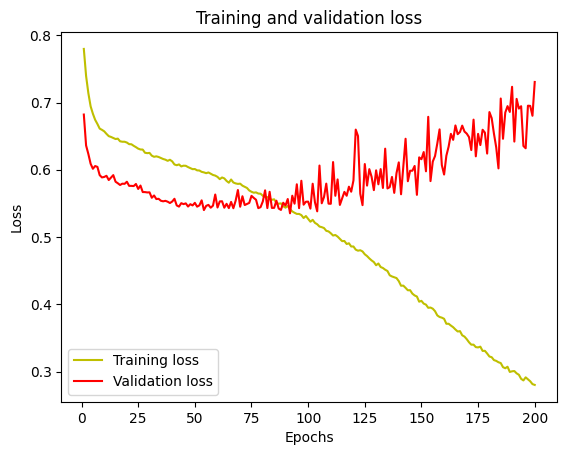

In [17]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

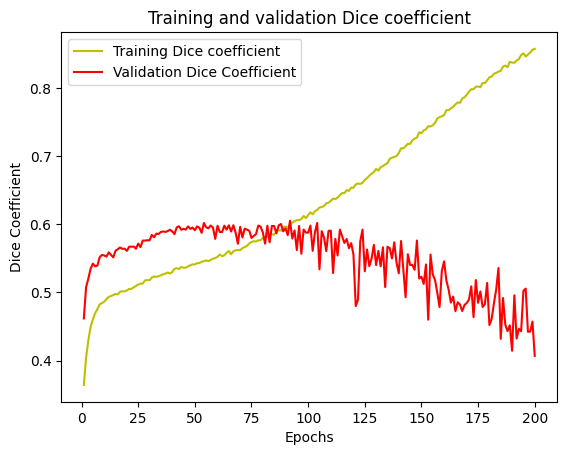

In [18]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [19]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                   | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_597667/1823746687.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_597667/1823746687.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|█████████████████

at 0.9: dice:  0.4337770469888204
at 0.8: dice:  0.4602037298718754
at 0.7: dice:  0.4737372020404746
at 0.6: dice:  0.48232000567613265
at 0.5: dice:  0.48847538189879885
at 0.4: dice:  0.49170492515825065
at 0.3: dice:  0.4911157675928836
at 0.2: dice:  0.4819181560274151
at 0.1: dice:  0.43602739148837566
at 0.05: dice:  0.3786949646889552
at 0.01: dice:  0.2656553520000511


# TRANSSKIP

In [14]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = r"/home/rabeea/logs/transskip_transunet_kvasir/4layers_lr3_e4_f64_350_d8_h2_m4.h5"
tensorboard = TensorBoard(log_dir=r"/home/rabeea/logs/transskip_transunet_kvasir/4layers_lr3_e4_f64_350_d8_h2_m4", histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [15]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-05-28 11:07:21.975005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801
2023-05-28 11:07:23.013129: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


700/700 [==============================] - 266s 347ms/step - loss: 0.8814 - dice_coef: 0.3622 - val_loss: 0.8394 - val_dice_coef: 0.4041
Epoch 2/350
700/700 [==============================] - 236s 337ms/step - loss: 0.8434 - dice_coef: 0.4000 - val_loss: 0.8172 - val_dice_coef: 0.4262
Epoch 3/350
700/700 [==============================] - 237s 339ms/step - loss: 0.8004 - dice_coef: 0.4430 - val_loss: 0.7664 - val_dice_coef: 0.4770
Epoch 4/350
700/700 [==============================] - 237s 339ms/step - loss: 0.7779 - dice_coef: 0.4655 - val_loss: 0.7111 - val_dice_coef: 0.5323
Epoch 5/350
700/700 [==============================] - 238s 339ms/step - loss: 0.7667 - dice_coef: 0.4765 - val_loss: 0.7113 - val_dice_coef: 0.5320
Epoch 6/350
700/700 [==============================] - 236s 337ms/step - loss: 0.7607 - dice_coef: 0.4825 - val_loss: 0.7087 - val_dice_coef: 0.5345
Epoch 7/350
700/700 [==============================] - 238s 340ms/step - loss: 0.7554 - dice_coef: 0.4878 - val_loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 235s 336ms/step - loss: 0.6876 - dice_coef: 0.5529 - val_loss: 0.6427 - val_dice_coef: 0.5977
Epoch 49/350
444/700 [==================>...........] - ETA: 1:19 - loss: 0.6940 - dice_coef: 0.5464

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 338ms/step - loss: 0.6860 - dice_coef: 0.5542 - val_loss: 0.6362 - val_dice_coef: 0.6040
Epoch 52/350
700/700 [==============================] - 236s 337ms/step - loss: 0.6831 - dice_coef: 0.5571 - val_loss: 0.6381 - val_dice_coef: 0.6020
Epoch 53/350
700/700 [==============================] - 236s 338ms/step - loss: 0.6832 - dice_coef: 0.5569 - val_loss: 0.6385 - val_dice_coef: 0.6016
Epoch 54/350
462/700 [==================>...........] - ETA: 1:13 - loss: 0.6899 - dice_coef: 0.5501

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 338ms/step - loss: 0.6595 - dice_coef: 0.5797 - val_loss: 0.6455 - val_dice_coef: 0.5937
Epoch 68/350
295/700 [===========>..................] - ETA: 2:04 - loss: 0.6300 - dice_coef: 0.6091

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 339ms/step - loss: 0.6551 - dice_coef: 0.5839 - val_loss: 0.6374 - val_dice_coef: 0.6016
Epoch 71/350
700/700 [==============================] - 237s 338ms/step - loss: 0.6578 - dice_coef: 0.5812 - val_loss: 0.6342 - val_dice_coef: 0.6047
Epoch 72/350
700/700 [==============================] - 237s 338ms/step - loss: 0.6532 - dice_coef: 0.5857 - val_loss: 0.6281 - val_dice_coef: 0.6108
Epoch 73/350
321/700 [============>.................] - ETA: 1:57 - loss: 0.6517 - dice_coef: 0.5872

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 338ms/step - loss: 0.6243 - dice_coef: 0.6137 - val_loss: 0.6568 - val_dice_coef: 0.5812
Epoch 87/350
700/700 [==============================] - 235s 336ms/step - loss: 0.6173 - dice_coef: 0.6206 - val_loss: 0.6375 - val_dice_coef: 0.6005
Epoch 88/350
700/700 [==============================] - 236s 337ms/step - loss: 0.6208 - dice_coef: 0.6171 - val_loss: 0.6352 - val_dice_coef: 0.6027
Epoch 89/350
700/700 [==============================] - 238s 341ms/step - loss: 0.6158 - dice_coef: 0.6221 - val_loss: 0.6616 - val_dice_coef: 0.5762
Epoch 90/350
327/700 [=============>................] - ETA: 1:56 - loss: 0.6148 - dice_coef: 0.6230

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.5707 - dice_coef: 0.6663 - val_loss: 0.6788 - val_dice_coef: 0.5581
Epoch 105/350
700/700 [==============================] - 237s 339ms/step - loss: 0.5673 - dice_coef: 0.6696 - val_loss: 0.6771 - val_dice_coef: 0.5598
Epoch 106/350
700/700 [==============================] - 237s 339ms/step - loss: 0.5689 - dice_coef: 0.6679 - val_loss: 0.6706 - val_dice_coef: 0.5663
Epoch 107/350
700/700 [==============================] - 237s 338ms/step - loss: 0.5640 - dice_coef: 0.6728 - val_loss: 0.6959 - val_dice_coef: 0.5408
Epoch 108/350
700/700 [==============================] - 236s 338ms/step - loss: 0.5612 - dice_coef: 0.6755 - val_loss: 0.6832 - val_dice_coef: 0.5535
Epoch 109/350
161/700 [=====>........................] - ETA: 2:47 - loss: 0.5851 - dice_coef: 0.6516

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 238s 339ms/step - loss: 0.5041 - dice_coef: 0.7318 - val_loss: 0.7390 - val_dice_coef: 0.4969
Epoch 124/350
700/700 [==============================] - 236s 338ms/step - loss: 0.5016 - dice_coef: 0.7343 - val_loss: 0.7470 - val_dice_coef: 0.4888
Epoch 125/350
700/700 [==============================] - 238s 339ms/step - loss: 0.4965 - dice_coef: 0.7393 - val_loss: 0.7593 - val_dice_coef: 0.4765
Epoch 126/350
700/700 [==============================] - 236s 337ms/step - loss: 0.4945 - dice_coef: 0.7412 - val_loss: 0.7652 - val_dice_coef: 0.4706
Epoch 127/350
700/700 [==============================] - 235s 336ms/step - loss: 0.4874 - dice_coef: 0.7483 - val_loss: 0.7319 - val_dice_coef: 0.5038
Epoch 128/350
 54/700 [=>............................] - ETA: 3:19 - loss: 0.4873 - dice_coef: 0.7484

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 339ms/step - loss: 0.4369 - dice_coef: 0.7981 - val_loss: 0.7600 - val_dice_coef: 0.4749
Epoch 142/350
700/700 [==============================] - 235s 336ms/step - loss: 0.4335 - dice_coef: 0.8014 - val_loss: 0.6990 - val_dice_coef: 0.5358
Epoch 143/350
700/700 [==============================] - 237s 339ms/step - loss: 0.4280 - dice_coef: 0.8069 - val_loss: 0.7842 - val_dice_coef: 0.4506
Epoch 144/350
700/700 [==============================] - 238s 340ms/step - loss: 0.4256 - dice_coef: 0.8092 - val_loss: 0.9049 - val_dice_coef: 0.3299
Epoch 145/350
700/700 [==============================] - 237s 339ms/step - loss: 0.4210 - dice_coef: 0.8137 - val_loss: 0.7623 - val_dice_coef: 0.4725
Epoch 146/350
111/700 [===>..........................] - ETA: 3:02 - loss: 0.4142 - dice_coef: 0.8205

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 238s 339ms/step - loss: 0.3848 - dice_coef: 0.8493 - val_loss: 0.7256 - val_dice_coef: 0.5085
Epoch 158/350
700/700 [==============================] - 236s 337ms/step - loss: 0.3837 - dice_coef: 0.8504 - val_loss: 0.7902 - val_dice_coef: 0.4439
Epoch 159/350
700/700 [==============================] - 236s 338ms/step - loss: 0.3781 - dice_coef: 0.8559 - val_loss: 0.8137 - val_dice_coef: 0.4203
Epoch 160/350
700/700 [==============================] - 236s 337ms/step - loss: 0.3769 - dice_coef: 0.8571 - val_loss: 0.7518 - val_dice_coef: 0.4821
Epoch 161/350
567/700 [=======================>......] - ETA: 41s - loss: 0.3694 - dice_coef: 0.8645

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 338ms/step - loss: 0.3481 - dice_coef: 0.8851 - val_loss: 0.7794 - val_dice_coef: 0.4538
Epoch 174/350
700/700 [==============================] - 235s 336ms/step - loss: 0.3466 - dice_coef: 0.8866 - val_loss: 0.7921 - val_dice_coef: 0.4411
Epoch 175/350
700/700 [==============================] - 237s 338ms/step - loss: 0.3438 - dice_coef: 0.8893 - val_loss: 0.8096 - val_dice_coef: 0.4235
Epoch 176/350
700/700 [==============================] - 236s 338ms/step - loss: 0.3420 - dice_coef: 0.8911 - val_loss: 0.7849 - val_dice_coef: 0.4481
Epoch 177/350
698/700 [============================>.] - ETA: 0s - loss: 0.3376 - dice_coef: 0.8954

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.3230 - dice_coef: 0.9094 - val_loss: 0.8971 - val_dice_coef: 0.3352
Epoch 190/350
700/700 [==============================] - 235s 336ms/step - loss: 0.3208 - dice_coef: 0.9114 - val_loss: 0.7863 - val_dice_coef: 0.4460
Epoch 191/350
700/700 [==============================] - 235s 336ms/step - loss: 0.3186 - dice_coef: 0.9136 - val_loss: 0.8402 - val_dice_coef: 0.3920
Epoch 192/350
700/700 [==============================] - 235s 336ms/step - loss: 0.3169 - dice_coef: 0.9152 - val_loss: 0.7512 - val_dice_coef: 0.4809
Epoch 193/350
274/700 [==========>...................] - ETA: 2:11 - loss: 0.3174 - dice_coef: 0.9147

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.3052 - dice_coef: 0.9263 - val_loss: 0.7691 - val_dice_coef: 0.4623
Epoch 205/350
626/700 [=========================>....] - ETA: 22s - loss: 0.3033 - dice_coef: 0.9281

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 338ms/step - loss: 0.3001 - dice_coef: 0.9312 - val_loss: 0.8304 - val_dice_coef: 0.4008
Epoch 208/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2996 - dice_coef: 0.9316 - val_loss: 0.8037 - val_dice_coef: 0.4275
Epoch 209/350
700/700 [==============================] - 237s 338ms/step - loss: 0.3031 - dice_coef: 0.9281 - val_loss: 0.9315 - val_dice_coef: 0.2996
Epoch 210/350
611/700 [=========================>....] - ETA: 27s - loss: 0.2974 - dice_coef: 0.9338

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 338ms/step - loss: 0.2920 - dice_coef: 0.9384 - val_loss: 0.8378 - val_dice_coef: 0.3926
Epoch 223/350
659/700 [===========================>..] - ETA: 12s - loss: 0.2892 - dice_coef: 0.9411

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.2874 - dice_coef: 0.9428 - val_loss: 0.8247 - val_dice_coef: 0.4055
Epoch 226/350
700/700 [==============================] - 236s 337ms/step - loss: 0.2894 - dice_coef: 0.9408 - val_loss: 0.8527 - val_dice_coef: 0.3775
Epoch 227/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2869 - dice_coef: 0.9432 - val_loss: 0.7912 - val_dice_coef: 0.4388
Epoch 228/350
634/700 [==========================>...] - ETA: 20s - loss: 0.2862 - dice_coef: 0.9438

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.2795 - dice_coef: 0.9500 - val_loss: 0.7895 - val_dice_coef: 0.4399
Epoch 239/350
597/700 [========================>.....] - ETA: 31s - loss: 0.2798 - dice_coef: 0.9495

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.2792 - dice_coef: 0.9501 - val_loss: 0.7986 - val_dice_coef: 0.4307
Epoch 242/350
625/700 [=========================>....] - ETA: 23s - loss: 0.2787 - dice_coef: 0.9505

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 338ms/step - loss: 0.2759 - dice_coef: 0.9531 - val_loss: 0.8084 - val_dice_coef: 0.4206
Epoch 246/350
700/700 [==============================] - 236s 337ms/step - loss: 0.2794 - dice_coef: 0.9496 - val_loss: 0.8252 - val_dice_coef: 0.4037
Epoch 247/350
226/700 [========>.....................] - ETA: 2:26 - loss: 0.2723 - dice_coef: 0.9567

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.2728 - dice_coef: 0.9556 - val_loss: 0.8622 - val_dice_coef: 0.3662
Epoch 257/350
685/700 [============================>.] - ETA: 4s - loss: 0.2722 - dice_coef: 0.9561

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 235s 336ms/step - loss: 0.2719 - dice_coef: 0.9563 - val_loss: 0.8574 - val_dice_coef: 0.3708
Epoch 260/350
696/700 [============================>.] - ETA: 1s - loss: 0.2708 - dice_coef: 0.9573

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 339ms/step - loss: 0.2698 - dice_coef: 0.9582 - val_loss: 0.8766 - val_dice_coef: 0.3514
Epoch 264/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2709 - dice_coef: 0.9570 - val_loss: 0.8474 - val_dice_coef: 0.3805
Epoch 265/350
319/700 [============>.................] - ETA: 1:57 - loss: 0.2704 - dice_coef: 0.9574

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 336ms/step - loss: 0.2668 - dice_coef: 0.9605 - val_loss: 0.8714 - val_dice_coef: 0.3558
Epoch 275/350
634/700 [==========================>...] - ETA: 20s - loss: 0.2685 - dice_coef: 0.9587

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.2669 - dice_coef: 0.9602 - val_loss: 0.8647 - val_dice_coef: 0.3623
Epoch 278/350
630/700 [==========================>...] - ETA: 21s - loss: 0.2648 - dice_coef: 0.9622

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 337ms/step - loss: 0.2647 - dice_coef: 0.9621 - val_loss: 0.8391 - val_dice_coef: 0.3877
Epoch 282/350
700/700 [==============================] - 236s 338ms/step - loss: 0.2643 - dice_coef: 0.9625 - val_loss: 0.8363 - val_dice_coef: 0.3904
Epoch 283/350
234/700 [=========>....................] - ETA: 2:23 - loss: 0.2652 - dice_coef: 0.9615

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 339ms/step - loss: 0.2612 - dice_coef: 0.9649 - val_loss: 0.8483 - val_dice_coef: 0.3778
Epoch 294/350
196/700 [=======>......................] - ETA: 2:36 - loss: 0.2688 - dice_coef: 0.9573

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 237s 339ms/step - loss: 0.2611 - dice_coef: 0.9649 - val_loss: 0.8594 - val_dice_coef: 0.3665
Epoch 296/350
644/700 [==========================>...] - ETA: 17s - loss: 0.2615 - dice_coef: 0.9645

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 238s 339ms/step - loss: 0.2598 - dice_coef: 0.9660 - val_loss: 0.8443 - val_dice_coef: 0.3814
Epoch 300/350
700/700 [==============================] - 236s 337ms/step - loss: 0.2599 - dice_coef: 0.9658 - val_loss: 0.8681 - val_dice_coef: 0.3576
Epoch 301/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2594 - dice_coef: 0.9662 - val_loss: 0.8353 - val_dice_coef: 0.3903
Epoch 302/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2640 - dice_coef: 0.9616 - val_loss: 0.8063 - val_dice_coef: 0.4193
Epoch 303/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2601 - dice_coef: 0.9654 - val_loss: 0.8408 - val_dice_coef: 0.3847
Epoch 304/350
700/700 [==============================] - 236s 338ms/step - loss: 0.2599 - dice_coef: 0.9656 - val_loss: 0.8676 - val_dice_coef: 0.3578
Epoch 305/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2598 - dice_coef: 0.9656 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



700/700 [==============================] - 236s 338ms/step - loss: 0.2544 - dice_coef: 0.9694 - val_loss: 0.8359 - val_dice_coef: 0.3879
Epoch 332/350
700/700 [==============================] - 235s 336ms/step - loss: 0.2537 - dice_coef: 0.9701 - val_loss: 0.8234 - val_dice_coef: 0.4004
Epoch 333/350
700/700 [==============================] - 236s 337ms/step - loss: 0.2533 - dice_coef: 0.9704 - val_loss: 0.8567 - val_dice_coef: 0.3670
Epoch 334/350
700/700 [==============================] - 236s 337ms/step - loss: 0.2562 - dice_coef: 0.9675 - val_loss: 0.7332 - val_dice_coef: 0.4905
Epoch 335/350
700/700 [==============================] - 236s 338ms/step - loss: 0.2543 - dice_coef: 0.9693 - val_loss: 0.8010 - val_dice_coef: 0.4226
Epoch 336/350
700/700 [==============================] - 237s 339ms/step - loss: 0.2531 - dice_coef: 0.9704 - val_loss: 0.8261 - val_dice_coef: 0.3975
Epoch 337/350
700/700 [==============================] - 237s 338ms/step - loss: 0.2533 - dice_coef: 0.9702 

In [16]:
a.load_weights(filepath)

In [17]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
print('training dice: ',max(acc))
print('validation dice: ',max(val_acc))

training dice:  0.9724375605583191
validation dice:  0.6107705235481262


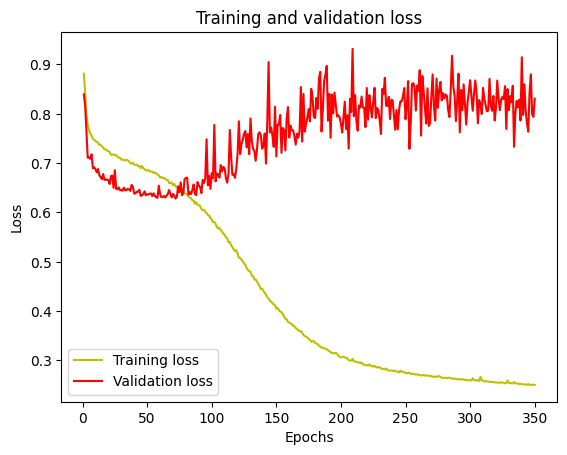

In [18]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

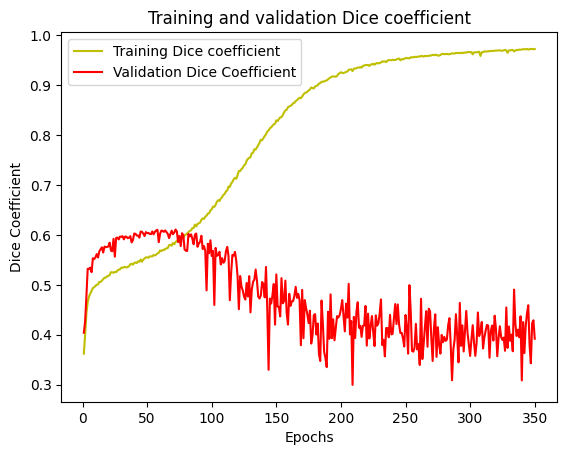

In [19]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [20]:
#test_gen = DataGen(image_size,testpath, batch_size=batch_size)
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for k in tqdm(range(len(testpath))):
    y_pred=a.predict(test_gen.__getitem__(k)[0])
    true_msk=test_gen.__getitem__(k)[1]
    y_pred_argmax=np.where(y_pred>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, true_msk))
    y_pred_argmax=np.where(y_pred>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, true_msk))
    
#     except:
#         print(k)
#         break
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                   | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_1536816/1823746687.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_1536816/1823746687.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|███████████████

at 0.9: dice:  0.45166943715964225
at 0.8: dice:  0.474185582280869
at 0.7: dice:  0.4895268413078218
at 0.6: dice:  0.5004435377717696
at 0.5: dice:  0.5073959714801057
at 0.4: dice:  0.5119274441031743
at 0.3: dice:  0.5070105696267573
at 0.2: dice:  0.48771426522699934
at 0.1: dice:  0.43799770222990003
at 0.05: dice:  0.3834653579442837
at 0.01: dice:  0.2815245790296762
